In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba as nb
import scipy as sc
import math
import time
from scipy.integrate import cumtrapz
from numba import jit, njit, prange

# LOAD PARAMETER

In [2]:
# Steady State Response
param_ssr = np.load('../model/ssr.npy')[-1]

# Dynamics
param_dynamics = np.load('../model/sys_id.npy')[-1]

# Generate Trajectory

## Step & ramp function

In [3]:
def step(tt):
    out = np.zeros_like(tt)
    out[tt >= 0] = 1
    return out

def ramp(tt):
    out = np.array(tt)
    out[tt < 0] = 0
    return out

def jitter(gain, omega, tt, t0, tf):
    out = np.array(tt)
    
    out = gain * np.sin(omega*(tt-t0))
    out[tt-t0 < 0] = 0
    out[tt-tf > 0] = 0
    return out

## Continuous acceleration

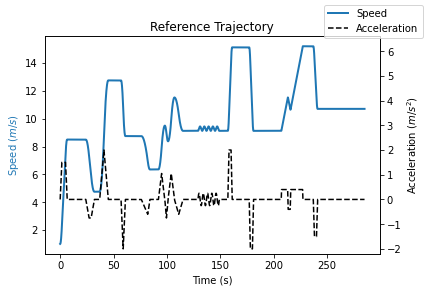

In [4]:
t0 = np.arange(3, 288, 0.02)
a0 = ramp(t0-3) - ramp(t0-4.5) - ramp(t0-8) + ramp(t0-9.5) \
    - 0.25*ramp(t0-27) + 0.25*ramp(t0-30) + 0.25*ramp(t0-32) - 0.25*ramp(t0-35) \
    + 0.5*ramp(t0-40) - 1.*ramp(t0-44) + 0.5*ramp(t0-48) \
    - 1*ramp(t0-60) + 2*ramp(t0 - 62) - 1*ramp(t0-64) \
    - 0.1*ramp(t0-79) + 0.4*ramp(t0-85) - 0.3*ramp(t0-87) \
    + 0.35*ramp(t0-95) - 0.7*ramp(t0-98) + 0.35*ramp(t0-101) \
    - 0.5*ramp(t0-101) + 1*ramp(t0-102.5) - 0.5*ramp(t0-104) \
    + 0.35*ramp(t0-104) - 0.7*ramp(t0-107) + 0.35*ramp(t0-110) \
    - 0.15*ramp(t0-110) + 0.3*ramp(t0-114) - 0.15*ramp(t0-118) \
    + jitter(0.25, np.pi / 2.0, t0, 132, 152) \
    + 2.*ramp(t0-160) - 2.*ramp(t0-161) - 2.*ramp(t0-163) + 2.*ramp(t0-164) \
    - 2.*ramp(t0 - 180) + 2*ramp(t0-181) + 2 *ramp(t0-183) - 2*ramp(t0-184) \
    + 2.0 * ramp(t0-210) - 2.0*ramp(t0-210.2) - 2.0*ramp(t0-216) + 2.0*ramp(t0-216.4)\
    + 2.0 * ramp(t0-218.4) - 2.0*ramp(t0-218.8)  - 2.0*ramp(t0 - 230) + 2.0*ramp(t0-230.2) \
    - 1.5*ramp(t0-240) + 1.5*ramp(t0-241) + 1.5*ramp(t0-243) - 1.5*ramp(t0-244) #\
    #+ 5.0*step(t0-255) - 5.0*step(t0-256)
t0 = np.arange(0, 285, 0.02)
v0 = cumtrapz(a0, t0, initial=0.) + 1.

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.plot(t0, v0, color='tab:blue', linewidth=2.0, label='Speed')
ax1.set_ylabel('Speed 'r'$(m/s)$', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(t0, a0, color='black', linestyle='--', linewidth=1.5, label='Acceleration')
ax2.set_ylabel('Acceleration '+r'$(m/s^2)$', color='black')
ax2.set_ylim(ax2.get_ylim()[0], 3 * ax2.get_ylim()[1])

fig.legend()
plt.title('Reference Trajectory')
# fig.savefig('images/trajectory', dpi=600)
plt.show()

In [5]:
# Untuk ngitung overshoot
idx = np.array([[9.5, 27.], [35., 40.], [48., 60.], [64., 79.], [87., 95.], [118., 132.], [164., 180.], [184., 210.], [230.2, 240.], [244., t0[-1]+3.]]) -3
direction = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
reg = np.ones(t0.shape[0])
for i in range(t0.shape[0]):
    for j in range(idx.shape[0]):
        if idx[j,0] <= t0[i] and t0[i] <= idx[j,1]:
            reg[i] = v0[i]

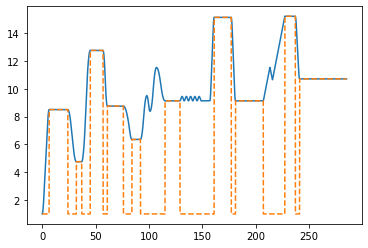

In [6]:
plt.plot(t0, v0)
plt.plot(t0, reg, linestyle='--')
#direction = np.array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1])

# MAKE FUNCTION

## Generate Population

In [7]:
def generate_population(num, dim, rng):
    """
    Generate flowers:
        Input:
            num: number of flowers (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            flws: initial position of the flowers (numpy array)
    """
    flws = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        flws[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return flws

## Forward Propagation

In [8]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

In [9]:
@njit
def clip(a, a_min, a_max):
    if a > a_max:
        return a_max
    elif a < a_min:
        return a_min
    else:
        return a
    
_ = clip(2.0, -1.0, 1.0)

In [10]:
# Steady state response parameters
beta1, beta2, beta3 = param_ssr

# System parameters
a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param_dynamics
td11 = int(np.around(td11))
td12 = int(np.around(td12))
td13 = int(np.around(td13))
td21 = int(np.around(td21))
td22 = int(np.around(td22))
td23 = int(np.around(td23))

In [11]:
sat_min = -1.
sat_max = 1.

@njit
def forward_propagation(t, v, param):    
    kp, ki, kd = param

    dt = np.mean(t[1:] - t[:-1])
    
    ki = ki * dt
    kd = kd / dt    
    
    e_sum = 0.0
    e_last = 0.0
    e_int_state = 0 # 0 --> No Saturation || 1 --> Saturation (+) || -1 --> Saturation (-1)
    is_start = True
    
    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):     
        # LONGITUDINAL CONTROLLER
        sp = clip(v[i], 0.0, np.Inf)
        sr = beta1 * (1 - np.exp(beta2*sp)) + beta3
        sr = clip(sr, 0., sat_max) * 0.5
        
        err = sp - y
        if e_int_state == 0:
            e_sum += err
        elif e_int_state == 1:
            if err < 0:
                e_sum += err
        elif e_int_state == -1:
            if err > 0:
                e_sum += err
        
        if is_start:
            temp = sr + kp * err + ki * e_sum + 0.
            is_start = False
        else:
            temp = sr + kp * err + ki * e_sum + kd * (err - e_last)
        
        e_last = err

        if temp > sat_max: # Saturation (+)
            temp = sat_max
            e_int_state = 1
        elif temp < sat_min: # Saturation (-)
            temp = sat_min
            e_int_state = -1
        else: # Not saturated
            e_int_state = 0
        
        u1 = clip(temp, 0.0, sat_max)
        u2 = clip(-temp, 0.0, -sat_min)
        
        # DYNAMICS     
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t  \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out, u1_list, u2_list
_ = forward_propagation(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

In [12]:
%timeit forward_propagation(t0, v0, np.array([0.2, 0.1550, 0.1]))

372 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Constraint

In [13]:
@njit
def admissible(param):
    kp, ki, kd = param
    if kp < 0. or ki < 0. or kd < 0.:
        return False
    else:
        return True
n_dim = 3
_ = admissible(np.random.randn(n_dim))

## Cost

In [14]:
@njit
def gradient(a, t):
    dt = np.mean(t[1:]-t[:-1])
    
#     forward = np.zeros_like(a)
#     forward[:-1] = a[1:]
#     forward[-1] = forward[-2]
#     backward = np.zeros_like(a)
#     backward[1:] = a[:-1]
#     backward[0] = backward[1]    
#     out = (forward - backward) / 2 / dt
    
    out = np.zeros_like(a)
    out[1:-1] = (a[2:] - a[:-2]) / 2 / dt
    out[0] = out[1]
    out[-1] = out[-2]
    return out
_ = gradient(v0, t0)

In [15]:
idx = np.array([[9.5, 27.], [35., 40.], [48., 60.], [64., 79.], [87., 95.], [118., 132.], [164., 180.], [184., 210.], [230.2, 240.], [244., t0[-1]+3.]]) -3
direction = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

@njit
def max_os_sim(mv):
    out = 0.
    for i in range(mv.shape[0]):
        for j in range(idx.shape[0]):
            if idx[j,0] <= t0[i] and t0[i] <= idx[j,1]:
                if direction[j] > 0.5:
                    temp = mv[i] - v0[i]
                else:
                    temp = v0[i] - mv[i]
                temp = temp / v0[i] * 100
                temp = clip(temp, 0.0, np.Inf)
                if temp > out:
                    out = temp
    return out
_ = max_os_sim(np.zeros(v0.shape[0]))

In [16]:
@njit
def cost(t, v, param, lamda):
    mv, cs1, cs2 = forward_propagation(t, v, param)
    
    error = v - mv
    
    # ma = gradient(mv, t)
    # mj = gradient(ma, t)
    
    # mj = gradient(error, t)
    # mj = gradient(mj, t)
    
    mj = gradient(cs1, t)
    
    max_os = max_os_sim(mv)
    if max_os > lamda[1]: # max_os %
        return np.Inf
    # loss = np.sum(np.abs(error)) + lamda[0] * np.sum(np.abs(mj))
    # loss = np.sum(error**2) + lamda[0] * np.sum(mj**2)
    loss = np.sum(error**2) + lamda[0] * np.sum(np.abs(mj))
    M = t.shape[0]
    return loss / M
_ = cost(np.arange(10, dtype=float), np.ones(10), np.ones(3), np.array([0.001, 0.001]))

In [17]:
@njit
def mean_squared_error(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    error = v - mv
    cost = np.mean(error**2)
    return cost
_ = mean_squared_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_error(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    error = v - mv
    out = np.mean(np.abs(error))
    return out
_ = mean_absolute_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def max_absolute_error(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    error = v - mv
    return np.max(np.abs(error))
_ = max_absolute_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_jerk(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    
    ma = gradient(mv, t)
    mj = gradient(ma, t)
    return np.mean(np.abs(mj))
_ = mean_absolute_jerk(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_squared_jerk(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    
    ma = gradient(mv, t)
    mj = gradient(ma, t)
    return np.mean(mj**2)
_ = mean_squared_jerk(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def max_percent_overshoot(t, v, param):
    mv, _, _ = forward_propagation(t, v, param)
    return max_os_sim(mv)
_ = max_percent_overshoot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_u_dot(t, v, param):
    mv, cs1, cs2 = forward_propagation(t, v, param)
    
    cs1_dot = gradient(cs1, t)
    cs2_dot = gradient(cs2, t)
    return np.mean(np.abs(cs1_dot)+np.abs(cs2_dot))
_ = mean_absolute_u_dot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_squared_u_dot(t, v, param):
    mv, cs1, cs2 = forward_propagation(t, v, param)
    
    cs1_dot = gradient(cs1, t)
    cs2_dot = gradient(cs2, t)
    return np.mean(np.abs(cs1_dot)**2+np.abs(cs2_dot)**2)
_ = mean_squared_u_dot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

In [18]:
@njit
def calculate_total_cost(param, lamda):
    if admissible(param):
        return cost(t0, v0, param, lamda)
    return np.Inf
_ = calculate_total_cost(np.array([0.1, 0.1, 0.1]), np.array([0.001, 0.001]))

In [19]:
@njit(parallel=True)
def flowers_cost(flowers, lamda):
    length = flowers.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(flowers[ii], lamda)
    return losses
_ = flowers_cost(np.array([[0.1, 0.1, 0.1], [0.1, 0.1, 0.1]]), np.array([0.001, 0.001]))

## Pollination

In [20]:
@njit(parallel = True)
def fpa(flowers, loss_flowers, global_, global_loss_, p, alpha, gamma, var, s0, lamda):
    num = flowers.shape[0]
    dim = flowers.shape[1]    
    out = np.empty(flowers.shape)
    temp = np.empty(dim)
    loss = np.empty(loss_flowers.shape)
    temp_loss = 0.
    random_number = np.random.uniform(0., 1., num)
    for i in prange(num):
        # GLOBAL POLLINATION
        if random_number[i] < p:
            # Generate Levy Flight
            upper = np.random.normal(0., np.sqrt(var), size=dim)
            lower = np.abs(np.random.normal(0., 1., size=dim))**(1./alpha)
            L = np.divide(upper, lower)
            
            for j in range(L.shape[0]):
                if L[j] < s0:
                    L[j] = s0
            
            temp = flowers[i] + gamma * L * (global_ - flowers[i])
        # LOCAL POLLINATION
        else:
            while(True):
                i1, i2 = np.random.randint(0, num, size=2)
                if i1==i2 or i1==i or i2==i:
                    if num <= 5: # For breaking the loop
                        None
                    else:
                        continue
                break
            epsilon = np.random.uniform(0.,1.)
            
            temp = flowers[i] + epsilon * (flowers[i1] - flowers[i2])
        
        # CALCULATE COST
        temp_loss = calculate_total_cost(temp, lamda)
        if np.isnan(temp_loss):
            temp_loss = np.Inf
        
        # UPDATE
        if temp_loss < loss_flowers[i]:
            out[i] = temp
            loss[i] = temp_loss
        else:
            out[i] = flowers[i]
            loss[i] = loss_flowers[i]
    
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    if global_loss_ > min_loss:
        global_loss_new = min_loss
        global_new = out[min_idx, :]
    else:
        global_new = global_
        global_loss_new = global_loss_
    
    return out, loss, global_new, global_loss_new

xx1 = np.ones((2, n_dim))
xx2 = np.ones(2)
xx3 = np.random.randn(n_dim)
_ = fpa(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1, 0.69, 0.1, np.array([0.001, 0.001]))

# SIMULATION (OPTIMIZATION)

In [21]:
num = 50
n_sim = 20
n_itr = 5000

r_kp = [0.0, 1.0]
r_ki = [0.0, 1.0]
r_kd = [0.0, 1.0]
rng = [r_kp, r_ki, r_kd]
dim = len(rng)

s0 = 0.1
p_threshold = 0.8
alpha = 1.5
gamma = 0.1
var = (math.gamma(1+alpha)/alpha/math.gamma((1+alpha)/2) * np.sin(np.pi * alpha/2)/2**((alpha-1)/2))**(1/alpha)

In [22]:
lamda = np.array([0.0, np.Inf])

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim) * np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    print(f'Optimization: {j+1} ------------------------------------------')
    
    print('Initializing ...')
    while True:
        try:
            flowers = generate_population(num, dim, rng)
            global_ = None
            global_loss_ = np.Inf

            loss_flowers = flowers_cost(flowers, lamda)
            loss_flowers[np.isnan(loss_flowers)] = np.Inf
            min_idx = np.argmin(loss_flowers)
            min_loss = loss_flowers[min_idx]
            if global_loss_ > min_loss:
                global_loss_ = min_loss
                global_ = flowers[min_idx, :]

            global_history = np.empty((n_itr, dim))
            global_history[0] = global_
            global_loss_history = np.empty(n_itr)
            global_loss_history[0] = global_loss_
            
            # Biasanya di sini suka gagal, kalau inisialisasi flowers awal semuanya menyelisihi constraint
            flowers, loss_flowers, global_, global_loss_ = fpa(flowers, loss_flowers, global_, global_loss_, p_threshold, alpha, gamma, var, s0, lamda)
            break
        except:
            print('Re-Initializing ...')
            
    print('Continue ...')
    for i in range(1, n_itr):
        # Flower Pollination Algorithm
        flowers, loss_flowers, global_, global_loss_ = fpa(flowers, loss_flowers, global_, global_loss_, p_threshold, alpha, gamma, var, s0, lamda)

        if (i-1) % 500 == 0:
            print('simulation: {} || iteration: {} || global_loss: {:.5f}'.format(j+1, i, global_loss_))

        global_history[i] = global_
        global_loss_history[i] = global_loss_

    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || the best loss: {:.10f}'.format(j, the_best_loss_history[-1]))

Optimization: 1 ------------------------------------------
Initializing ...
Continue ...
simulation: 1 || iteration: 1 || global_loss: 0.00184
simulation: 1 || iteration: 501 || global_loss: 0.00096
simulation: 1 || iteration: 1001 || global_loss: 0.00096
simulation: 1 || iteration: 1501 || global_loss: 0.00096
simulation: 1 || iteration: 2001 || global_loss: 0.00096
simulation: 1 || iteration: 2501 || global_loss: 0.00096
simulation: 1 || iteration: 3001 || global_loss: 0.00096
simulation: 1 || iteration: 3501 || global_loss: 0.00096
simulation: 1 || iteration: 4001 || global_loss: 0.00096
simulation: 1 || iteration: 4501 || global_loss: 0.00096
simulation: 0 || the best loss: 0.0009613256
Optimization: 2 ------------------------------------------
Initializing ...
Continue ...
simulation: 2 || iteration: 1 || global_loss: 0.00429
simulation: 2 || iteration: 501 || global_loss: 0.00096
simulation: 2 || iteration: 1001 || global_loss: 0.00096
simulation: 2 || iteration: 1501 || global_l

In [23]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of flowers\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# Lambda value\n')
f.writelines('lambda0: {}'.format(lamda[0]))
f.writelines('lambda1: {}'.format(lamda[1]))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('r_kp: {}\n'.format(r_kp))
f.writelines('r_ki: {}\n'.format(r_ki))
f.writelines('r_kd: {}\n'.format(r_kd))
f.writelines('\n# The FPA hyperparameters\n')
f.writelines('s0: {}\n'.format(s0))
f.writelines('p_threshold: {}\n'.format(p_threshold))
f.writelines('alpha: {}\n'.format(alpha))
f.writelines('gamma: {}\n'.format(gamma))
f.writelines('var: {}\n'.format(var))
f.close()

In [24]:
print('Lambda')
print(lamda)
print('Parameters')
print(global_)
print('Total loss: {}'.format(global_loss_))
print('MAE: {}'.format(mean_absolute_error(t0, v0, global_)))
print('MAJ: {}'.format(mean_absolute_jerk(t0, v0, global_)))
print('MSJ: {}'.format(mean_squared_jerk(t0, v0, global_)))
print('MAUD: {}'.format(mean_absolute_u_dot(t0, v0, global_)))
print('maximum %OS: {}'.format(max_percent_overshoot(t0, v0, global_)))

Lambda
[ 0. inf]
Parameters
[0.91199778 1.58133762 0.03292953]
Total loss: 0.000961325616161638
MAE: 0.008337801759689942
MAJ: 0.42471862619516915
MSJ: 2.663425029312554
MAUD: 0.03601539583189666
maximum %OS: 0.9136797000140781


In [25]:
print('MSUD: {}'.format(mean_squared_u_dot(t0, v0, np.array([0.56458294, 2.2533995,  0.07817718]))))

MSUD: 27.819735851337157


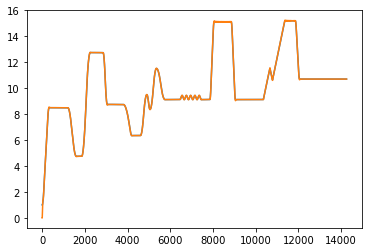

In [26]:
mv, cs1, cs2 = forward_propagation(t0, v0, global_)
plt.plot(v0)
plt.plot(mv)

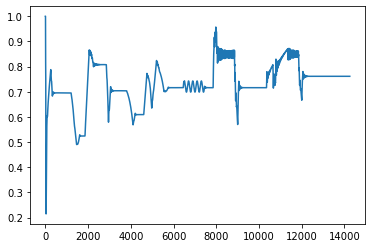

In [27]:
plt.plot(cs1)

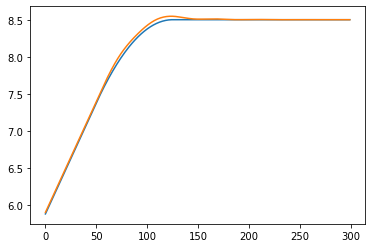

In [28]:
eo = 200
el = 500
plt.plot(v0[eo:el])
plt.plot(mv[eo:el])